Gavin Gunawardena \
INFS 770 \
Assignment 4 \
Dr. Liu

In [1]:
#library Imports and setup
import pandas as pd
import numpy as np
import gensim
import os
import re 
import nltk
import matplotlib as plt
from re import sub, compile
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import *
from sklearn import metrics, model_selection
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import normalize
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.models import LdaModel
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split
%matplotlib inline

,pid,helpful,score,text,category
0,B000GAYQL8,0/0,5,GREAT WATCH AND GREAT LOOK. BIG FACE AND 4 DIF...,watch
1,B000IBNPDA,0/0,5,"Bought this as a Christmas gift, my boyfriend ...",watch
2,B000J2HA16,0/0,5,"I love this watch! Its sporty, without looking...",watch
3,B000BDIQPM,0/0,5,"Works great,looks nice,dont have to worry abou...",watch
4,B000GZTH9E,0/3,4,I need to change the watch wrist and I havent ...,watch


score:


2     259
3     303
1     595
4     773
5    2070
Name: score, dtype: int64

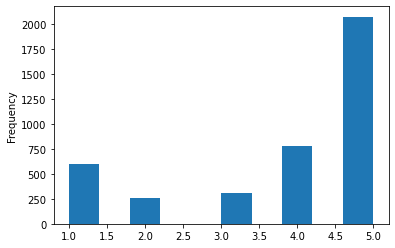

category:


watch          1000
software       1000
electronics    1000
automotive     1000
Name: category, dtype: int64

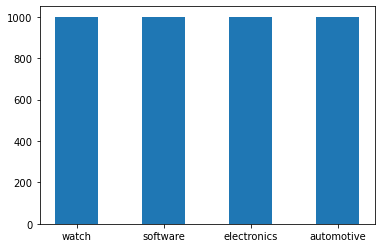

In [2]:
#Task 1: Read the dataset

#import data
df_Amazon_Reviews = pd.read_csv('amazon_review_texts.csv')

#Read first 5 lines
display(df_Amazon_Reviews.head())

#Show distribution of Score variable
print('score:')
display(df_Amazon_Reviews['score'].value_counts(ascending=True))
df_Amazon_Reviews['score'].plot.hist()
plt.pyplot.show()

#Show distribution of Category variable
print('category:')
display(df_Amazon_Reviews['category'].value_counts())
categories = df_Amazon_Reviews['category'].value_counts().index
counts = df_Amazon_Reviews['category'].value_counts().values
plt.pyplot.bar(categories, counts, width=0.5)
plt.pyplot.show()



In [20]:
#Task 2: Tokenize the reviews

# get a set of stopwords
stopwords = set(nltk.corpus.stopwords.words("english"))

import re
def before_token(documents):
    # conver words to lower case
    lower = map(str.lower, documents)
    # remove puntuations
    punctuationless = list(map(lambda x: " ".join(re.findall('\\b\\w\\w+\\b',x)), lower))
    # remove numbers
    return list(map(lambda x:re.sub('\\b[0-9]+\\b', '', x), punctuationless))

# initialize a stemmer
stemmer = nltk.stem.PorterStemmer()

# initialize a container of token frequencies
fdist = nltk.FreqDist()


# define a function that preprocess a single document and returns a list of tokens
def preprocess(doc):
    tokens = []
    for token in doc.split():
        if token not in stopwords:
            tokens.append(stemmer.stem(token))
    return tokens
            
# preprocess all documents
processed = list(map(preprocess, before_token(df_Amazon_Reviews.text)))

  watch     use     one    work    time    like product   great     get   would 
   2553    2476    1795    1605    1420    1375    1336    1318    1309    1217 


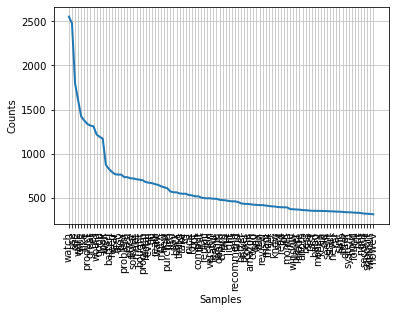

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [4]:
#Show word frequency distribution
fdist = nltk.FreqDist([token for doc in processed for token in doc])
fdist.tabulate(10)
fdist.plot(100)

Task 3: Which of the top 10 words might not be useful in text clustering and classification, and why?\
*The purpose of this type of text analysis is to label the sentiment of the product by the reviewer and possibly categorize the sentiment based on sub-categories which may be based on aspects  of the product such as ease of use or customer service. Thus, the most useful words would be nouns since they represent subjects that the reviews could be about, adverbs, since they describe verbs based on actions conducted or influenced by the subject that the review could be about, and adjectives since they describe subjects. From the top 10  most frequent words, the mose useful would likely be: watch, one, work, time, product, and great.*

In [5]:
#Task 4: Write code to reconstruct the documents
processed_doc = list(map(" ".join, processed))
vectorizer = TfidfVectorizer(norm = 'l2', max_df=0.8, stop_words='english')
X = vectorizer.fit_transform(processed_doc)
print("n_samples: %d, n_features: %d" % X.shape)

n_samples: 4000, n_features: 10833


In [6]:
#Task 5: Write code to perform K-means to categorize documents into 4 clusters.
km = KMeans(n_clusters=4, max_iter=100, random_state=54321)
km.fit(X)

# examine each word's distance to each cluster
km.transform(X)
km.predict(X[0])

# examine the representative words for each cluster
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(4):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print

Cluster 0:
 use
 product
 work
 great
 good
 instal
 program
 like
 softwar
 time
Cluster 1:
 batteri
 charg
 charger
 power
 adapt
 appl
 camera
 canon
 work
 origin
Cluster 2:
 watch
 look
 band
 time
 great
 wear
 love
 like
 nice
 price
Cluster 3:
 bed
 air
 inflat
 comfort
 pump
 sleep
 mattress
 deflat
 airb
 easi


Task 6: Discuss how well you think these top 10 words describe the 4 product categories.\
\
*All but the first cluster seem to describe the categories well. Clusters 1-4 each seem to each describe a category quite well: a time-based software, a Canon camera, an Apple wristwatch, and an inflatable air bed; due to the nouns and adjectives they contain. The first cluster is not as effective as the others since the nouns and adjectives it contains only describe a software product that possibly has something to do with time, but this does fit its category, software.*

In [7]:
#Task 7: Build a topic model using Latent Dirichlet Allocation based on the 
#vectorized data from Task 4.

word2id = dict((k, v) for k, v in vectorizer.vocabulary_.items())
id2word = dict((v, k) for k,v in vectorizer.vocabulary_.items())
d=corpora.Dictionary()
d.id2token = id2word
d.token2id = word2id
corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)
#print(id2word)
# build the lda model with 4 topics
lda = LdaModel(corpus, num_topics=4,id2word=id2word, random_state=10, passes=20) #
print(lda.print_topics())

[(0, '0.002*"dent" + 0.001*"la" + 0.001*"el" + 0.001*"harley" + 0.001*"en" + 0.001*"es" + 0.001*"inspector" + 0.001*"c350" + 0.001*"producto" + 0.001*"que"'), (1, '0.006*"use" + 0.004*"product" + 0.004*"softwar" + 0.004*"work" + 0.004*"program" + 0.004*"game" + 0.003*"comput" + 0.003*"instal" + 0.003*"like" + 0.003*"version"'), (2, '0.013*"watch" + 0.006*"great" + 0.005*"batteri" + 0.005*"work" + 0.005*"look" + 0.005*"use" + 0.005*"good" + 0.005*"time" + 0.004*"product" + 0.004*"price"'), (3, '0.001*"oil" + 0.001*"sd950i" + 0.001*"nuff" + 0.001*"powerful" + 0.001*"aid" + 0.000*"reali" + 0.000*"fro" + 0.000*"dammag" + 0.000*"aliv" + 0.000*"cpap"')]


Task 8: Examine the representative words for each topic. Please create a text box and discuss how well these words describe the 4 product categories, and also tell me which unsupervised method (clustering vs LDA) you think is more effective in identifying the categories in this example and why? \
\
*The representative words for the 4 topics make it easy to distinguish all of the products, although the automotive and electronic products are only distinguishable because these 2 topics include model names as part of their word lists. If the LDA topics did not include the model numbers, they would definitely be less effective since two of the topics do not include very descriptive words, but since they do and the remaining topics are just as descriptive as the word lists obtained from k-means clustering, I believe LDA is more effective in identifying the categories.*

In [8]:
#Task 9: Perform a 5 fold cross validaiton using SGD classifier to predict 
#the review scores using texts.
# define a custom tokenizer
def tokenization(text):
    # replace mention 
    text = sub("@[^ ]+", " ", text)
    # replace hashtags with space
    text = sub("#[^ ]+", " ", text)
    # replace RT (retweet) with space
    text = sub("RT", " ", text)
    # replace URL with space
    text = sub("http[^ ]+", " ", text)

    p = compile("[^a-z]")
    # conver the text to lower case and split by non-alphabetic characters
    # also remove "" due to tokenizing multple spaces
    return [token for token in p.split(text.lower()) if token != ""]

# SGD Classifier with 5-fold cross validation
skf = StratifiedKFold(n_splits=5)
fold = 0
f1 = []
for train_index, test_index in skf.split(df_Amazon_Reviews["text"], df_Amazon_Reviews["category"]):
#for train_index, test_index in skf:
    fold += 1
    print("Fold %d" % fold)
    # partition
    train_x, test_x = df_Amazon_Reviews["text"].iloc[train_index], df_Amazon_Reviews["text"].iloc[test_index]
    train_y, test_y = df_Amazon_Reviews["category"].iloc[train_index], df_Amazon_Reviews["category"].iloc[test_index]
    # vectorize
    vectorizer = TfidfVectorizer(tokenizer=tokenization, max_df=0.8, min_df=1, stop_words='english')
    X = vectorizer.fit_transform(train_x)
    X_test = vectorizer.transform(test_x)
    # train model
    clf = SGDClassifier(random_state=fold)
    clf.fit(X, train_y)
    # predict
    pred_y = clf.predict(X_test)
    # classification results
    for line in metrics.classification_report(test_y, pred_y).split("\n"):
        print(line)
    f1.append(metrics.f1_score(test_y, pred_y, average='weighted'))
print("Average F1: %.2f" % np.mean(f1))

Fold 1
              precision    recall  f1-score   support

  automotive       0.90      0.96      0.93       200
 electronics       0.92      0.90      0.91       200
    software       0.95      0.94      0.94       200
       watch       0.98      0.94      0.96       200

    accuracy                           0.94       800
   macro avg       0.94      0.94      0.94       800
weighted avg       0.94      0.94      0.94       800

Fold 2
              precision    recall  f1-score   support

  automotive       0.89      0.91      0.90       200
 electronics       0.93      0.90      0.91       200
    software       0.93      0.96      0.95       200
       watch       0.96      0.94      0.95       200

    accuracy                           0.93       800
   macro avg       0.93      0.93      0.93       800
weighted avg       0.93      0.93      0.93       800

Fold 3
              precision    recall  f1-score   support

  automotive       0.88      0.94      0.91       200


In [9]:
#Task 10: Write code to create a new variable named “satisfaction”. 
#If a review score is 5 or 4, set the satisfaction value to 1 
#(the customer is satisfied). For the other review scores (3, 2, or 1), 
#set the satisfaction value to 0 (the customer is not satisfied). 
#Use this as a new dependent variable and run an SGD classifier with a 5 fold
#cross validation

#Create the satisfcation column
df_Amazon_Reviews.loc[(df_Amazon_Reviews['score'] >= 4), 'satisfaction'] = 1
df_Amazon_Reviews.loc[(df_Amazon_Reviews['score'] < 4), 'satisfaction'] = 0 


# SGD Classifier with 5-fold cross validation
skf = StratifiedKFold(n_splits=5)
fold = 0
f1 = []
for train_index, test_index in skf.split(df_Amazon_Reviews["text"], df_Amazon_Reviews["satisfaction"]):
#for train_index, test_index in skf:
    fold += 1
    print("Fold %d" % fold)
    # partition
    train_x, test_x = df_Amazon_Reviews["text"].iloc[train_index], df_Amazon_Reviews["text"].iloc[test_index]
    train_y, test_y = df_Amazon_Reviews["satisfaction"].iloc[train_index], df_Amazon_Reviews["satisfaction"].iloc[test_index]
    # vectorize
    vectorizer = TfidfVectorizer(tokenizer=tokenization, max_df=0.8, min_df=1, stop_words='english')
    X = vectorizer.fit_transform(train_x)
    X_test = vectorizer.transform(test_x)
    # train model
    clf = SGDClassifier(random_state=fold)
    clf.fit(X, train_y)
    # predict
    pred_y = clf.predict(X_test)
    # classification results
    for line in metrics.classification_report(test_y, pred_y).split("\n"):
        print(line)
    f1.append(metrics.f1_score(test_y, pred_y, average='weighted'))
print("Average F1: %.2f" % np.mean(f1))


Fold 1
              precision    recall  f1-score   support

         0.0       0.85      0.23      0.36       231
         1.0       0.76      0.98      0.86       569

    accuracy                           0.77       800
   macro avg       0.81      0.60      0.61       800
weighted avg       0.79      0.77      0.71       800

Fold 2
              precision    recall  f1-score   support

         0.0       0.63      0.68      0.66       231
         1.0       0.87      0.84      0.85       569

    accuracy                           0.79       800
   macro avg       0.75      0.76      0.75       800
weighted avg       0.80      0.79      0.80       800

Fold 3
              precision    recall  f1-score   support

         0.0       0.65      0.73      0.68       231
         1.0       0.88      0.84      0.86       569

    accuracy                           0.81       800
   macro avg       0.76      0.78      0.77       800
weighted avg       0.81      0.81      0.81       800

In [10]:
#Task 11: Use Bing Liu’s opinion lexicon described in the lecture as the vocabulary, 
#and vectorize the texts again.

# read the lexicon
lexicon_BLiu = dict()

# read postive words
with open("opinion-lexicon-Bing-Liu-English/negative-words.txt", "r") as in_file:
    for line in in_file.readlines():
        if not line.startswith(";") and line != "\n":
            lexicon_BLiu[line.strip()] = -1

# read negative words
with open("opinion-lexicon-Bing-Liu-English/positive-words.txt", "r") as in_file:
    for line in in_file.readlines():
        if not line.startswith(";") and line != "\n":
            lexicon_BLiu[line.strip()] = 1
            
# SGD Classifier with 5-fold cross validation
skf = StratifiedKFold(n_splits=5)
fold = 0
f1 = []
Bing_Liu_Vocab = lexicon_BLiu.keys()
for train_index, test_index in skf.split(df_Amazon_Reviews["text"], df_Amazon_Reviews["satisfaction"]):
#for train_index, test_index in skf:
    fold += 1
    print("Fold %d" % fold)
    # partition
    train_x, test_x = df_Amazon_Reviews["text"].iloc[train_index], df_Amazon_Reviews["text"].iloc[test_index]
    train_y, test_y = df_Amazon_Reviews["satisfaction"].iloc[train_index], df_Amazon_Reviews["satisfaction"].iloc[test_index]
    # vectorize
    vectorizer = TfidfVectorizer(tokenizer=tokenization, max_df=0.8, min_df=1, stop_words='english', vocabulary=Bing_Liu_Vocab)
    X = vectorizer.fit_transform(train_x)
    X_test = vectorizer.transform(test_x)
    # train model
    clf = SGDClassifier(random_state=fold)
    clf.fit(X, train_y)
    # predict
    pred_y = clf.predict(X_test)
    # classification results
    for line in metrics.classification_report(test_y, pred_y).split("\n"):
        print(line)
    f1.append(metrics.f1_score(test_y, pred_y, average='weighted'))
print("Average F1: %.2f" % np.mean(f1))


Fold 1
              precision    recall  f1-score   support

         0.0       0.73      0.41      0.53       231
         1.0       0.80      0.94      0.86       569

    accuracy                           0.79       800
   macro avg       0.76      0.67      0.69       800
weighted avg       0.78      0.79      0.77       800

Fold 2
              precision    recall  f1-score   support

         0.0       0.69      0.63      0.66       231
         1.0       0.85      0.88      0.87       569

    accuracy                           0.81       800
   macro avg       0.77      0.76      0.76       800
weighted avg       0.81      0.81      0.81       800

Fold 3
              precision    recall  f1-score   support

         0.0       0.67      0.65      0.66       231
         1.0       0.86      0.87      0.87       569

    accuracy                           0.81       800
   macro avg       0.77      0.76      0.76       800
weighted avg       0.81      0.81      0.81       800

Task 12: Has the average F1 score increased in T11, compared with results obtained in T10? If so, why? \
\
*Yes by 1 percent, likely because using the Bing Liu opinion lexicon used to train the SGD Classifier model along with using the training dataset is more effective than just using the training dataset.*


In [16]:
#Task 13: Use TFIDF to vectorize the dataset again using the same 
#vectorizer you used in T9 and then perform PCA variable reduction 
#(Here you need to do vectorization first to obtain a dataset that includes 
#the TF-IDF numbers

#Setup vectorizer
vectorizer = TfidfVectorizer(tokenizer=tokenization, max_df=0.8, min_df=1, stop_words='english')
X = vectorizer.fit_transform(df_Amazon_Reviews["text"]).todense()
#Scale the dataset
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)
#print(len(X[0]))
#Initial primary component analysis
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized',whiten=True).fit(X)
#print(pca.explained_variance_ratio_)
sumofvariance=0.0
n_components = 0
for item in pca.explained_variance_ratio_:
    sumofvariance += item
    n_components+=1
    if sumofvariance>=0.9:
        break
print("Principal Component Count: %d" % n_components)
pca = PCA(n_components=n_components, svd_solver='randomized',whiten=True).fit(X)
X_train_pca = pca.transform(X)
train_x, test_x, train_y, test_y = train_test_split(X_train_pca, df_Amazon_Reviews["category"], test_size=0.2, stratify=df_Amazon_Reviews["category"], random_state=123)

Principal Component Count: 2221


Task 14: Use your own words to briefly describe PCA. \
\
*PCA, or principle component analysis, is a type of feature selection algorithm that attempts to lower the amount of features by lowering the dimensionality of a dataset and creating new variables to be used. It creates these new variables from existing variables by first converting the dataset into a covariance matrix and then obtaining the eigenvectors that contribute to the most variance. A feature vector is created from these chosen eigenvectors and a transpose of this feature vector is then multiplied by a matching transpose of the original dataset, resulting in a version of the original dataset with less features. This method requires that the dataset be standardized since it is extremely sensitive to high ranges within features.*\
*source of concept of definition: https://builtin.com/data-science/step-step-explanation-principal-component-analysis*


In [12]:
#Task 15: Please write code to determine how many principle components 
#you obtain if you make sure that these components explain at least 90% 
#of variance. 
#Setup vectorizer
vectorizer = TfidfVectorizer(tokenizer=tokenization, max_df=0.8, min_df=1, stop_words='english')
X = vectorizer.fit_transform(df_Amazon_Reviews["text"]).todense()
#Scale the dataset
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)
print(len(X[0]))
#Initial primary component analysis
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized',whiten=True).fit(X)
print(pca.explained_variance_ratio_)
sumofvariance=0.0
n_components = 0
for item in pca.explained_variance_ratio_:
    sumofvariance += item
    n_components+=1
    if sumofvariance>=0.9:
        break
print("Principal Component Count: %d" % n_components)
pca = PCA(n_components=n_components, svd_solver='randomized',whiten=True).fit(X)
X_train_pca = pca.transform(X)


15022
[1.08441678e-02 3.89168527e-03 3.16405030e-03 ... 1.25400895e-37
 2.34038219e-38 1.14562972e-39]
Principal Component Count: 2221


In [13]:
# SGD Classifier with 5-fold cross validation
skf = StratifiedKFold(n_splits=5)
fold = 0
f1 = []
for train_index, test_index in skf.split(X_train_pca, df_Amazon_Reviews["satisfaction"]):
#for train_index, test_index in skf:
    fold += 1
    print("Fold %d" % fold)
    # partition
    train_x, test_x = X_train_pca[train_index,], X_train_pca[test_index,]
    train_y, test_y = df_Amazon_Reviews["satisfaction"].iloc[train_index], df_Amazon_Reviews["satisfaction"].iloc[test_index]
    # train model
    clf = SGDClassifier(random_state=fold)
    clf.fit(train_x, train_y)
    # predict
    pred_y = clf.predict(test_x)
    # classification results
    for line in metrics.classification_report(test_y, pred_y).split("\n"):
        print(line)
    f1.append(metrics.f1_score(test_y, pred_y, average='weighted'))
print("Average F1: %.2f" % np.mean(f1))


Fold 1
              precision    recall  f1-score   support

         0.0       0.54      0.16      0.25       231
         1.0       0.73      0.95      0.83       569

    accuracy                           0.72       800
   macro avg       0.64      0.55      0.54       800
weighted avg       0.68      0.72      0.66       800

Fold 2
              precision    recall  f1-score   support

         0.0       0.42      0.13      0.19       231
         1.0       0.72      0.93      0.81       569

    accuracy                           0.70       800
   macro avg       0.57      0.53      0.50       800
weighted avg       0.64      0.70      0.63       800

Fold 3
              precision    recall  f1-score   support

         0.0       0.53      0.21      0.30       231
         1.0       0.74      0.92      0.82       569

    accuracy                           0.72       800
   macro avg       0.63      0.57      0.56       800
weighted avg       0.68      0.72      0.67       800

Task 16: Has the average F1 score increased in Task 15 compared with results obtained in task 10? If so, why?

*No, it decreased by .11, likely because one of the effects of primary component analysis, which is the only major difference between what was used in task 15 compared to task 10 other than vectorization of the training dataset in task 10, is that it lowers complexity of the dataset at the cost of accuracy.*
\
*source: https://builtin.com/data-science/step-step-explanation-principal-component-analysis*